<h3 align="center">NEU 437/537</h3>
<h4 align="center">Princeton University, Spring 2022</h4>

---
## Homework 2: Low Dimensional Dynamics and PCA
#### Due: Friday, Mar 18 

---
### Formatting Instructions
- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Ctrl+M M` for Markdown and `Ctrl+M Y` for Code). 

- **Submitting your homework**:  Please submit an .ipynb file via the assignment tab in Canvas. (From your notebook, File->Download->Download .ipynb).  Late submissions will be penalized 10% per day.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without  errors by selecting `Runtime -> Restart & Run All`. 


---
Setup: let's run a magic command (to force inline plotting) and then import some of our favorite packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm 

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from IPython import display
from matplotlib.lines import Line2D

In [2]:
colors = plt.cm.Dark2(np.linspace(0, 1, 10))
colors_pairs = plt.cm.Paired(np.linspace(0, 1, 12))

cmap = 'Greys'

In this problem set we will be exploring the concept of low dimensional dynamics in neural data. Our starting point will be the Hopfield network.

## Description of Hopfield networks: 


Consider a network of ${N}$ neuron-like elements. 

Let $u_{i}$ represent the membrane potential of neuron $i$ 

Let $f\left(u_{i}\right)$ represent the firing rate of neuron $i$ 

In the network, the neurons excite or inhibit each other according to connections $W_{i, j}$ from neuron $j$ to neuron $i$. 

Then, the system evolves according to the dynamics given by:
$$
\tau \dot{u}_{i}=-u_{i}+\sum_{j=1}^{N} W_{i, j} f\left(u_{j}\right), \quad i=1,2, \ldots, N
$$
For simplicity, we're going to take $\tau=1$ and $f\left(u_{i}\right)=\tanh \left(\beta u_{i}\right)$, a sigmoidal function between $-1$ and 1 with slope $\beta$ at the origin. ( $f\left(u_{i}\right)=-1$ will correspond to zero firing rate and $f\left(u_{i}\right)=1$ to the maximal firing rate.) 

The weights $W_{i, j}$ are positive for excitatory connections and negative for inhibitory connections.


John Hopfield (now professor emeritus at Princeton) recognized the capability of such a network to function as an associative memory. Memories are stored as **stable fixed points** of the system and can be recalled from a reasonably noisy input by letting the dynamics flow to the fixed point. You can learn more about Hopfield networks from the 2 papers by John Hopfield:
1. Hopfield, J. J. (1982). Neural networks and physical systems with emergent collective computational abilities. Proceedings of the national academy of sciences, 79(8), 2554-2558.
2. Hopfield, J. J. (1984). Neurons with graded response have collective computational properties like those of two-state neurons. Proceedings of the national academy of sciences, 81(10), 3088-3092.


## Storing memories in the connection weights: 

Before any memories are stored in the network, start with $W_{i, j}=0$ for all $i$ and $j$. Suppose we want the network to remember an $N$-dimensional pattern column vector $\vec \xi$ whose components are real numbers between $-1$ and 1
$$\vec \xi = \begin{bmatrix} \xi_1\\ \xi_2\\ ...\\ \xi_N \end{bmatrix}  $$

Fortuitously, the network can represent this pattern by adjusting its firing rates $u_i$ for each neuron $i$ such that $f(u_i) = \tanh (\beta u_i) = \xi_i$. 

Then a new memory $\vec \xi =\vec  f\left(u^{*}\right)$ can be stored in the system by incrementing $W_{i, j}$ by
$$
\Delta W_{i, j} = \begin{cases}
\left [  \vec \xi \vec \xi  ^{\top}\right ]_{i, j} =f\left(u_{i}^{*}\right) f\left(u_{j}^{*}\right) \text{ if } i \neq j\\
0 \mkern156mu  \text{ if } i = j\\
\end{cases}
$$
* $\vec \xi \vec \xi  ^{\top}$ is the matrix formed by the outer product of the pattern vector $\vec \xi$  with itself
* $ \left [  \vec \xi \vec \xi  ^{\top}\right ]_{i, j} $ is the $i$-th row, $j$-th column element of that matrix
* Note that we constrain all the diagonal elements of W are zero. This means that a neuron is not connected to itself

Think of this as imposing pattern $f\left(u^{*}\right)$ on the network; during that time the connections between neurons change according to the above rule. Afterward, the network "remembers" pattern $f\left(u^{*}\right)$ in the sense that $u^{*}$ has become a fixed point of the dynamics. The interesting thing about this is that to store a global pattern $f\left(u^{*}\right)$, the connection between neurons $i$ and $j$ just needs to know about what neurons $i$ and $j$ do in pattern $f\left(u^{*}\right)$. It doesn't need to know about any of the other neurons. In this sense the above rule for $W_{i, j}$ is local. Yet with this local rule we get global behavior.

For this problem set, we will use a network of 100 neurons, meaning the dynamics of our network exists in 100-dimensional space. This means we can interpret the firing rates (or membrane potential) of the population of neurons as a vector in a 100 dimensional space. However, when we run the network with three memories stored, the network always settles down to only a handful of states. This is the concept of low dimensional dynamics: the number of states that the network visits is much smaller than all possible states it could visit. This is an idea we have been exposed to several times already in this class (e.g. Wong and Wang 2006 , Kaufman et al. 2014 , etc.). Low dimensional dynamics are an extremely active area of research right now.
We would like to find a way to view the activity of our network in the smallest number of dimensions that capture all the interesting dynamics. The tool we will be using to find those low dimensional representations is called PCA (Principal Components Analysis). Beware: PCA and its variants are sometimes called other things in other fields. PCA finds the ordered set of orthogonal vectors that align with the most variance in the data. That is, the first principal component is aligned with the direction in the data that had the most variation across repeated observations. The second principal component is aligned with the direction that is orthogonal to the first principal component, and had the second most variation. Our goal is to find the set of principal components, examine how much of the variance is captured by a small number of dimensions, and then project the evolution of our network's dynamics into a low dimensional representation that is easy to look at.

## QUESTION 1. Finding the Principal Components of our Network Dynamics.
Our first step is to create a data matrix where each row is one observation of the network's state, and each column is a variable (neuron) in the network. We'll start with a network that only stores one memory. In our simulation, each memory $f(u)$ will be a vector of length 100 representing a 10 -by-10 binary image.
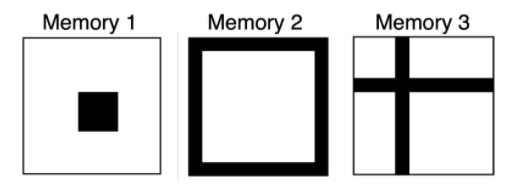

1a. So, first thing's first. We need to create a memory! Let's try one that looks like "Memory 1 " in the image above. We can do this by creating a $10 \times 10$ matrix of $1 \mathrm{~s}$, except with a square with corners $(5,5)$ and $(7,7)$ set to -1.
- Visualize this "memory" by creating a plot of the matrix (I suggest using either imshow in python or imagesc in MATLAB). **(2 points)**

<font color="red"> Answer in code </font>

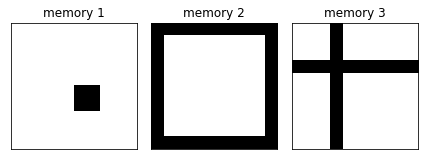

In [3]:
# YOUR CODE HERE TO CREATE MEMORY
mem1 = np.ones((10,10))
mem1[5:7,5:7] = -1
mem1*=-1

mem2 = np.ones((10,10))
mem2[1:9,1:9] = -1

mem3 = np.ones((10,10))
mem3[3,:] = -1
mem3[:,3] = -1
mem3*=-1

# plot memory
plt.subplot(1,3,1)
plt.title('memory 1')
plt.xticks([])
plt.yticks([])
plt.imshow(mem1.reshape(10, 10), cmap=cmap)

plt.subplot(1,3,2)
plt.title('memory 2')
plt.xticks([])
plt.yticks([])
plt.imshow(mem2.reshape(10, 10), cmap=cmap)

plt.subplot(1,3,3)
plt.title('memory 3')
plt.xticks([])
plt.yticks([])
plt.imshow(mem3.reshape(10, 10), cmap=cmap)

plt.tight_layout()

plt.show()

In [4]:
# add memory to Hopfield net
def update(u,W):
    '''
    Inputs: 
        u: nx1 memory vector
        W: nxn weight matrix
    Returns:
        W: nxn updated weight matrix
    '''
    W_copy = W.copy()
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_copy[i,j] = W[i,j] + (u[i] * u[j])
            if i == j:
                W_copy[i,j] = 0
    
    return W_copy

1b. Store your newly created memory in the network weights by reshaping it into a vector of length 100. Initialize The network weights `W` as a zeros vector of size (100, 100). **(1 point)**

The `update` function is provided below, which sets up the weights in the network as in the section **Storing memories in the connection weights**. 

<font color="red"> Answer in code </font>

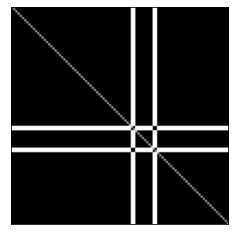

In [5]:
# YOUR CODE HERE TO STORE PATTERN IN CONNECTION WEIGHTS
w_init = np.zeros((100,100))
W1 = update(mem1.reshape(100), w_init)

plt.imshow(W1, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

1c. Now, simulate the network 50 times. To do this, use the provided function  `generate_noise` to generate a vector of noise, which serves as the initial condition to the network. Each of the 50 simulations should correspond to one of the noisy initial conditions produced by `generate_noise`.
- Then, use the provided function `runDynamics` to simulate the network using Euler's method, and find what the 50 random initial conditions end up as after the dynamics are run. 
  - Use $\beta=4, d t=0.001$, and $T=30$) where $T$ is the number of time steps. Read the documentation to understand how to call the function. 
  
  - For each of the 50 solutions, save the final state of the network (state at timestep $=T$) as a row in your data matrix. **(2 points)**

- Create a plot showing the results of all 50 simulations (for ease of visualization, I recommend creating a $10 \times 5$ set of subplots).  **(1 point)**

Do the results look like you expect?
 

Hint: One interesting aspect of Hopfield networks is that when you store a memory, its sign-flipped mirror is also stable. This is sometimes called an anti-memory, or mirror memory. By storing one memory (and its mirror), there are two possible states the network will settle towards. 

<font color="red"> Answer in code </font>

In [6]:
# generate random noise vector
def generate_noise(N):
    '''
    Inputs: 
        N: length of vector
    Returns:
        n: Nx1 noise vector
    '''
    n = (np.random.rand(N, 1) * 2) - 1
    
    return n

# run Hopfield net dynamics
def runDynamics(u, W, Beta, T, dt):
    '''
    Inputs: 
        u: 1xn vector of firing rates-- the initial condition of the system
        W: nxn weight matrix
        Beta: 
        T: number of time steps (scalar, int or float)
        dt: size of time step (scalar, float)
    Returns:
        np.tanh(u): 1xn vector of firing rates
    '''
    
    # transform from initial firing rate to initial membrane potential
    u = np.arctanh((u*.9)+0j)/Beta # input to arctanh must be complex
    
    nsteps = int(T/dt)
    
    for t in range(nsteps):
        oldU = u
        u = oldU + dt*(-oldU + W@np.tanh(u))
    
    # return back final firing rate
    firing_rate = np.squeeze(np.tanh(u)).real
    return firing_rate





In [7]:
T = 30
dt = 0.001
Beta = 4

n_sims = 50

# YOUR CODE HERE TO SIMULATE THE NETWORK 50 TIMES
data_mem1 = np.zeros((n_sims, 100)) # create data matrix to store final states

for i in tqdm(range(n_sims)): # simulate model 50 times
    # random initial condition here
    init_firing_rates = generate_noise(100)
    data_mem1[i, :] = runDynamics(init_firing_rates, W1, Beta, T, dt)

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


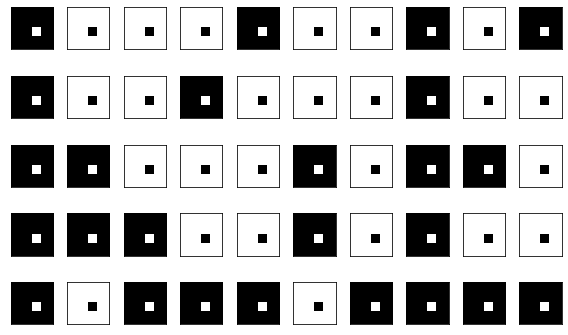

In [8]:
# plot 50 simulations
plt.figure(figsize=(8,5))    
for i in range(n_sims):   
    plt.subplot(5,10,i+1)
    plt.imshow(data_mem1[i, :].reshape(10,10), cmap=cmap)

    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()    
plt.show()

1d. Now we want to find the first 10 principal components of the `data` matrix you found in the previous question using `sklearn.decomposition.PCA` or SVD.
Plot the variance explained as a function of the number of principal components kept. **(2 points)**

<font color="red"> Answer in code </font>


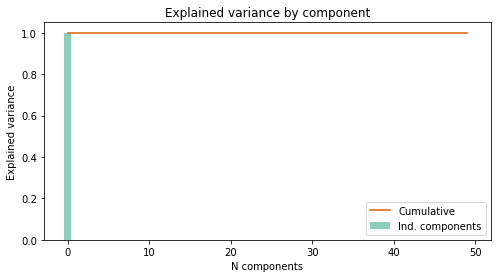

In [9]:
# YOUR CODE HERE TO COMPUTE PCS AND VARIANCE EXPLAINED PER COMPONENT
pca_mem1 = PCA()
pca_mem1.fit(data_mem1)
explained_variance_by_component_mem1 = pca_mem1.explained_variance_ratio_

# YOUR CODE HERE TO PLOT # OF PCS VS. VARIANCE EXPLAINED

plt.figure(figsize=(8,4))
plt.title('Explained variance by component')

plt.plot(range(n_sims), np.cumsum(explained_variance_by_component_mem1),  
     label='Cumulative', color=colors[2])

plt.bar(range(n_sims), explained_variance_by_component_mem1, 
         alpha=.5, color=colors[1], label='Ind. components')

plt.xlabel('N components')
plt.ylabel('Explained variance')

plt.legend()

plt.show()


1e. From plot of the number of principal components vs. the captured variance, how many dimensions do the network steady states exist in? **(1 point)**

<font color="red"> One dimension is sufficient to capture 100% of the variacne, i.e., the network steady states exist in 1 dimension </font>


How does this relate to the number of memories stored in the network? **(1 point)**

<font color="red"> One dimension reflects the one stored memory </font>


What do you think will happen to the network steady state dimensionality as we store more memories into the weight matrix? **(1 point)**

<font color="red"> Generally speaking, I expect the network steady-state dimensionality to increase with the number of added memories. However, there will be an upper limit on the storage (i.e., how many memories can the network store). This limit will result in a saturation of the dimensionality increase. </font>


## QUESTION 2. Projecting the network in a subspace.  

2a. 
The principal components define a set of coordinates that tell us where the most action is going on as the network evolves. Let's watch that process unfold. 

Edit the code cell below to  simulate the network from many random initial conditions
-  Run `runDynamicsPCA` with arguments $\beta=4, d t=0.001$ seconds ) for $T = 30$ seconds.  **(1 point)**
- On each time step, project the network's activity $\vec v$ onto the first principal component $\vec u$ where the projection is defined as the dot product between $\vec v$ and $\vec u$, divided by the squared norm of $\vec u$ **(1 point)**
$$ proj(\vec v,\vec u)= \frac { \vec v \cdot \vec u} {\vec u \cdot \vec u }=\frac { \vec v \cdot \vec u} {\|\vec u\|^2  }$$ 

- Store the projection in a matrix for each time step and simulation. **(1 point)**
 
- Create a plot of the projection vs. time for each simulation.  **(1 point)**
 
- When the network reaches a stable state, color code that trajectory to what state it ended up at and stop plotting that projection. **(1 point)**

<font color="red"> Answer in code </font>

Here is an example of what your evolving plot should look like.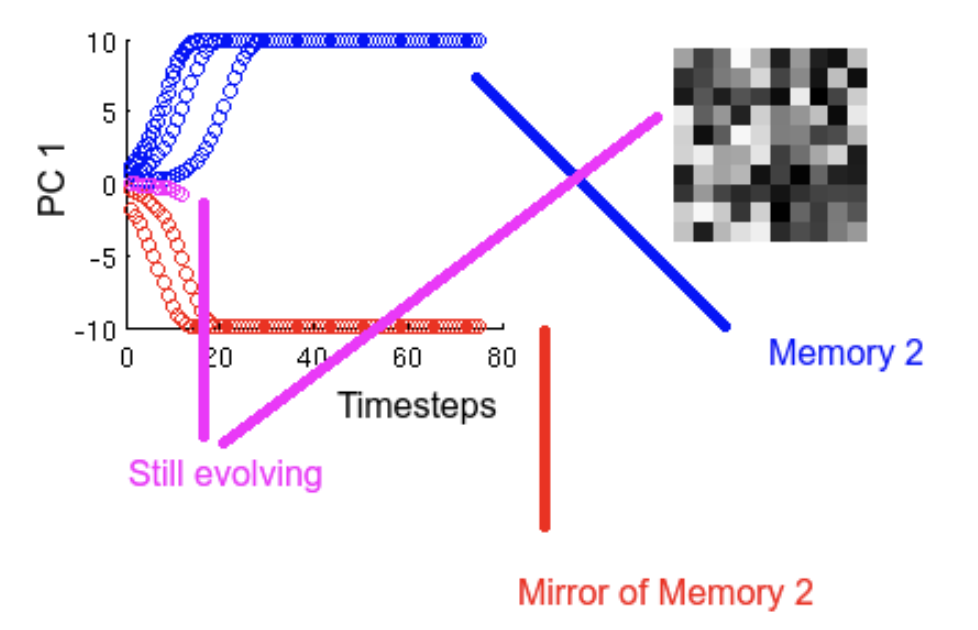

In [10]:
# run Hopfield net dynamics
def runDynamicsPCA_1(u,W,Beta,T,dt, projector):
    '''
    Inputs: 
        u: 1xn memory vector
        W: nxn weight matrix
        Beta: 
        T: number of time steps (scalar, int or float)
        dt: size of time step (scalar, float)
        projector: 1xn vector to project onto
    Returns:
        np.tanh(u): 1xn vector of firing rates
    '''
    
    # transform from initial firing rate to initial membrane potential
    u = np.arctanh((u*.9)+0j)/Beta # input to arctanh must be complex
    
    nsteps = int(T/dt)
    u_history = np.empty((nsteps, 100))
    projections = np.zeros(nsteps).astype(complex)  
    
    for t in range(nsteps):
        oldU = u
        u = oldU + dt*(-oldU + W@np.tanh(u))
        
        # YOUR CODE HERE TO PROJECT u ONTO projector
        projections[t] = np.dot(u.flatten(), projector)/\
                                    np.dot(projector, projector)
        u_history[t] = np.squeeze(np.tanh(u))
        
    # return back final firing rate and projection onto 
    firing_rate = np.squeeze(np.tanh(u))

    
    return firing_rate.real, projections.real, u_history.real


In [11]:
# simulate the network
pcs_mem1 = PCA().fit(data_mem1)

data_mem1_ = np.empty((n_sims, 100)) 
proj_mem1 = np.zeros((n_sims, int(T/dt))).astype(complex)
firing_rate_history_mem1 = np.zeros((n_sims, int(T/dt), 100))

sim_mem1 = []


# YOUR CODE HERE TO COMPUTE 1ST PC
first_pca_component = pcs_mem1.components_[0]

for i in tqdm(range(n_sims)): # simulate 50 trajectories
    # random initial condition
    init_firing_rates = generate_noise(100)
    
    data_mem1_[i, :], proj_mem1[i, :], firing_rate_history_mem1[i,:] =\
            runDynamicsPCA_1(init_firing_rates, W1,
                             Beta, T, dt, first_pca_component)

    sim_mem1.append(int((data_mem1_[i, :].reshape(10,10)==mem1).all()))

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [12]:
time_steps = int(T/dt)

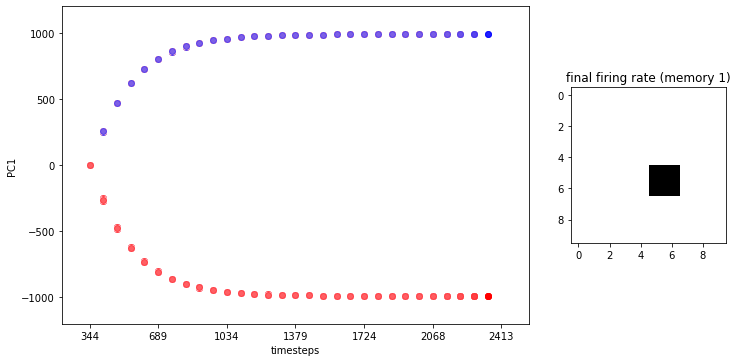

In [13]:
import time
time_sleep = 1e-1000
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(10,5))
fig.tight_layout()
ax[0].set_xticklabels(np.linspace(0, 10e3 ,30, dtype=int))
for i in range(10):  ### TAKES A WHILE TO RUN (so i only plot the first 10..).....

    xdata = []
    for t in np.linspace(0, 10e3 ,30, dtype=int):
        ax[0].set_xlim(-2,32)
        ax[0].set_ylim(-1200,1200)
        
        xdata.append(proj_mem1[i,t])
        line, = ax[0].plot(xdata, 'o', color='pink', alpha=.5)
        ax[0].set_xlabel('timesteps')
        ax[0].set_ylabel('PC1')
        
        #plt.subplot(1,2,2)
        ax[1].set_title('final firing rate (memory 1)')
        ax[1].imshow(firing_rate_history_mem1[i, t, :].reshape(10,10), cmap='Greys', )
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(time_sleep)

    if sim_mem1[i]==0:
        line.set_color('blue')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(time_sleep)

     
    if sim_mem1[i]==1:
        line.set_color('red')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(time_sleep)
        

display.clear_output(wait=True)
plt.show()

 <font color="red">Let's zoom in the first ~500 times step over all simulations:</font>

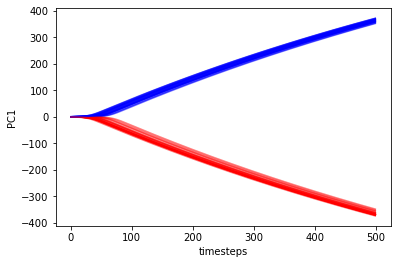

In [14]:
for i in range(n_sims):
    
    if sim_mem1[i]==0:
        plt.plot(proj_mem1[i,:500], c='blue', alpha=.5)

     
    if sim_mem1[i]==1:
        plt.plot(proj_mem1[i,:500], c='red', alpha=.5)
        
plt.xlabel('timesteps')
plt.ylabel('PC1')   
plt.show()

<font color="red"> Lastly, here are some examples of firing rate development from random init state to either the memory or the mirror memory. Each row is a random simulation- showing 10 sampled timesteps.</font>

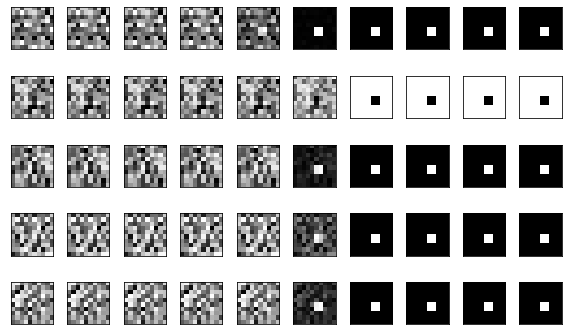

In [15]:
# plot 50 simulations
plt_i = 1
plt.figure(figsize=(8,5))    
for i in np.random.choice(range(50), 5): # 5 random sims
    for t in np.logspace(0,10,base=2, num=10, dtype=int):
        
        plt.subplot(5,10, plt_i)
        plt.imshow(firing_rate_history_mem1[i, t, :].reshape(10,10), 
                   cmap=cmap)
        plt_i+=1
        
        plt.xticks([])
        plt.yticks([])



plt.tight_layout()    
plt.show()


2b. From the plot you created, does the first principal component separate final states of the network? 
- Explain why this happens. 
- Why do all the trajectories start near 0 on the PC-1 axis? **(2 points)**


<font color="red"> The first principal component separates the final states of the network. At the beggining of learning, the network is random and the PC is at a non seperable state, 0. The seperability increases as the learning continues. </font>


## QUESTION 3. Make the dynamics more complex by adding a second memory. 

What happens if we add another memory to the network? 

3a. Create Memory 2 by creating a $10 \times 10$ matrix of $1 \mathrm{~s}$, except with the entire border set to -1. Plot your memory to make sure that you did this correctly.
- Update the weights $W$
- Simulate the network 50 times.
- Create a plot showing the results of all 50 simulations. **(3 points)**


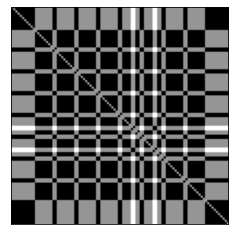

In [16]:
# YOUR CODE HERE TO UPDATE THE WEIGHTS W

W2 = update(mem2.reshape(100), W1)

plt.imshow(W2, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
data_mem2 = np.zeros((n_sims, 100)) # create data matrix to store final states

for i in tqdm(range(n_sims)): # simulate model 50 times
    # random initial condition here
    init_firing_rates = generate_noise(100)
    data_mem2[i, :] = runDynamics(init_firing_rates, W2, Beta, T, dt)
    

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


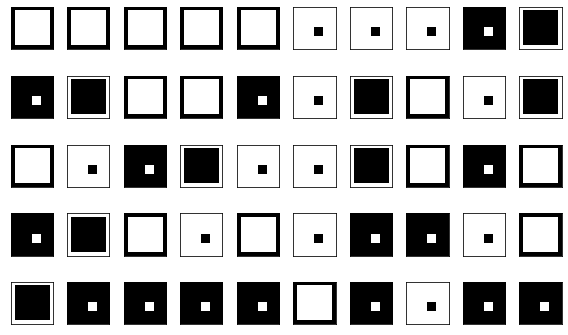

In [18]:
# plot 50 simulations
plt.figure(figsize=(8,5))    
for i in range(n_sims):   
    plt.subplot(5,10,i+1)
    plt.imshow(data_mem2[i, :].reshape(10,10), cmap=cmap)
    
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()    
plt.show()

3b. What do the network end states look like now?
- Compute PCA of the final states. **(1 point)**
- Make a plot of the explained variance. **(1 point)**

<font color="red"> Answer in code </font>

- How many principal components have non-zero variance explained? Why? **(1 point)**

<font color="red"> Two PCs. This makes sense with the intuition from above - assigning dimensions to memories. We now have 2 indepedent memories, and 2 PCs that capture their variance. </font>


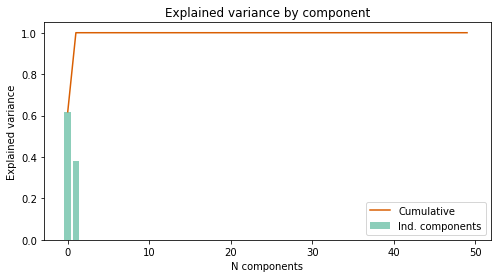

In [19]:
# YOUR CODE HERE TO COMPUTE PCS AND VARIANCE EXPLAINED PER COMPONENT
pca_mem2 = PCA()
pca_mem2.fit(data_mem2)
explained_variance_by_component_mem2 = pca_mem2.explained_variance_ratio_

# YOUR CODE HERE TO PLOT # OF PCS VS. VARIANCE EXPLAINED

plt.figure(figsize=(8,4))
plt.title('Explained variance by component')

plt.plot(range(n_sims), np.cumsum(explained_variance_by_component_mem2),  
     label='Cumulative', c=colors[2])

plt.bar(range(n_sims), explained_variance_by_component_mem2, 
         alpha=.5, color=colors[1], label='Ind. components')

plt.xlabel('N components')
plt.ylabel('Explained variance')

plt.legend()

plt.show()


3c. Now let’s once again project the network in a subspace. Simulate the network as in question 2. Change the function `runDynamicsPCA_2` in the code cell below, by projecting the network’s activity onto the appropriate number of principal components. Ideally, the function should work for a variable number of principal components, since we will later try to project the network's activity to more components. **(2 points)**

<font color="red"> Answer in code </font>


In [20]:
def runDynamicsPCA_2(u,W,Beta,T,dt, projectors, history=False):
    '''
    Inputs: 
        u: 1xn memory vector
        W: nxn weight matrix
        Beta: 
        T: number of time steps (scalar, int or float)
        dt: size of time step (scalar, float)
        projectors: mxn vector to project onto (m vectors)
    Returns:
        np.tanh(u): 1xn vector of firing rates
    '''
    
    # transform from initial firing rate to initial membrane potential
    u = np.arctanh((u*.9)+0j)/Beta # input to arctanh must be complex

    nsteps = int(T/dt)
    u_history = np.empty((nsteps, 100))
    
    projections = np.zeros((nsteps, projectors.shape[0])).astype(complex) 
    
    for t in range(nsteps):
        oldU = u
        u = oldU + dt*(-oldU + W@np.tanh(u))
        # YOUR CODE HERE TO PROJECT u ONTO projector
        for p in range(projectors.shape[0]):
            u_history[t] = np.squeeze(np.tanh(u))
            projections[t, p] = np.dot(u.flatten(), projectors[p])/\
                                    np.dot(projectors[p], projectors[p])

    # return back final firing rate and projection 
    firing_rate = np.squeeze(np.tanh(u))

    # return the real part, since we initialized complex arrays
    if history:
        return firing_rate.real, projections.real, u_history 
    return firing_rate.real, projections.real





3d. On the same plot, make a plot of the projection onto the first principal component against time for each of the 50 simulations **(1 point)**
- On the same plot, make a plot of the projection onto the second principal component against time for each of the 50 simulations **(1 point)**
-  Make an additional plot of the projection of the network onto the plane defined by the first and second PCs. Use color coding to separate out the final states of each trajectory. **(1 point)**

<font color="red"> Answer in code </font>



In [21]:
# simulate the network
pcs_mem2 = PCA().fit(data_mem2)

data_mem2_ = np.empty((n_sims, 100)) 
proj_mem2 = np.zeros((n_sims, int(T/dt), 2)).astype(complex)

# YOUR CODE HERE TO COMPUTE 1ST & 2ND PC
first_2pca_component = pcs_mem2.components_[:2]

for i in tqdm(range(n_sims)): # simulate 50 trajectories
    # random initial condition
    init_firing_rates = generate_noise(100)
    
    data_mem2_[i, :], proj_mem2[i, :], =\
            runDynamicsPCA_2(init_firing_rates, W2,
                             Beta, T, dt, first_2pca_component)


    

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


In [22]:
# get memory for sim
sim_mem2=[]
for i in tqdm(range(n_sims)):
    if (data_mem2_[i, :].reshape(10,10)==mem1).all():
        sim_mem2.append(0)
    elif (data_mem2_[i, :].reshape(10,10)==-1*mem1).all():
        sim_mem2.append(1)
        
    elif (data_mem2_[i, :].reshape(10,10)==mem2).all():
        sim_mem2.append(2)
    elif (data_mem2_[i, :].reshape(10,10)==-1*mem2).all():
        sim_mem2.append(3)
    else:
        print('outlier')
        plt.imshow(data_mem2[i,:].reshape(10,10), cmap=cmap)

100%|██████████| 50/50 [00:00<00:00, 48590.18it/s]


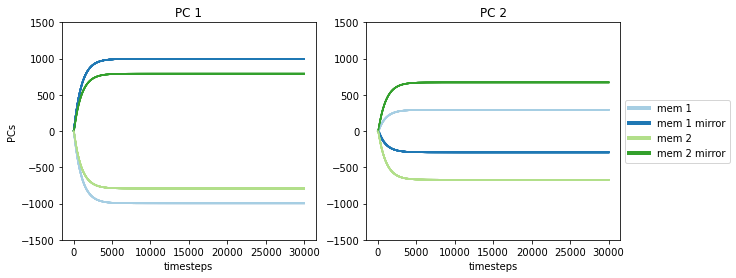

In [23]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('PC 1')

for i in range(50):
    plt.plot(proj_mem2[i,:,0], c=colors_pairs[sim_mem2[i]]) 
plt.ylim(-1500,1500)
plt.xlabel('timesteps')
#plt.ylabel('PC 1')
plt.ylabel('PCs')

plt.subplot(1,2,2)
plt.title('PC 2')
plt.ylim(-1500,1500)
# YOUR CODE HERE TO PLOT PC1 VS. TIME
for i in range(50):
    plt.plot(proj_mem2[i,:,1], c=colors_pairs[sim_mem2[i]]) 

plt.xlabel('timesteps')

legend_elements_mem2 = [Line2D([0], [0], color=colors_pairs[0], lw=4, label='mem 1'),
                   Line2D([0], [0], color=colors_pairs[1], lw=4, label='mem 1 mirror'),
                  Line2D([0], [0], color=colors_pairs[2], lw=4, label='mem 2'),
                  Line2D([0], [0], color=colors_pairs[3], lw=4, label='mem 2 mirror')]

# Create the figure
plt.legend(handles=legend_elements_mem2, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

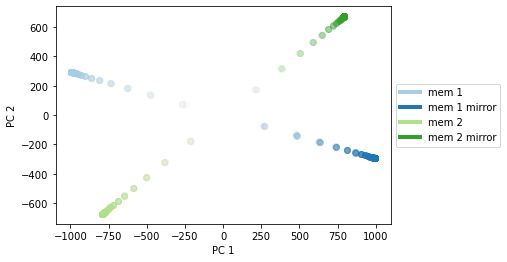

In [24]:
for i in range(n_sims):
    for t in np.linspace(0, 10e3 ,30, dtype=int):
        plt.scatter(proj_mem2[i,t,0], 
                    proj_mem2[i,t,1], 
                    alpha=t/time_steps, 
                    color=colors_pairs[sim_mem2[i]])

# Create the figure
plt.legend(handles=legend_elements_mem2, 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### transperacy spectrum coresponds to time step, 
# where brightest color is the final one.

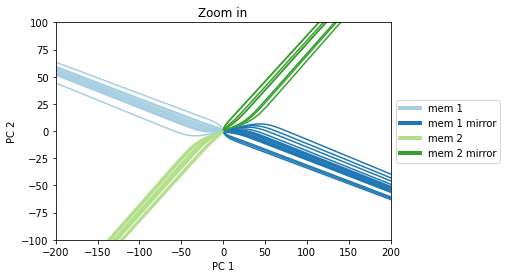

In [25]:
plt.title('Zoom in')
for i in range(n_sims):
    plt.plot(proj_mem2[i,:,0], 
                proj_mem2[i,:,1], 
                color=colors_pairs[sim_mem2[i]])

# Create the figure
plt.legend(handles=legend_elements_mem2, 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim(-200,200)
plt.ylim(-100,100)
plt.show()

3e. Does 1 PC separate trajectories like it did earlier?
In the PC1 v PC2 plot, are trajectories separated by their final states? Do all trajectories that end up in the same space take the same path? Why? **(2 points)**

<font color="red"> The first PC does separate the trajectories as before - based on their mirror state. It is enough to seperate the 2 memories.
    The second PC separates along the mirror plane but now captures the variance of the mirror plane on a spun memory 2. PC 2 is, however, not nessecary to separate the trajectories.
    Not all trajectories that end up in the same space take the same path. This is because, despite having the same end state, their initial state - governing the progress until convergence- is randomly assigned. 

</font>



## QUESTION 4. Add a Third Memory

4a. Finally, repeat everything with a third memory. CAUTION: If you add Memory 3, things will get significantly more complicated because you will create hybrid memories that are stable. Instead, make a new memory that has no overlap with the other memories we added. 
- Create a plot showing what your third memory looks like. **(1 point)**
- Create a plot showing the results of all 50 simulations. **(1 point)**
- Plot the explained variance.  **(1 point)**

<font color="red"> Answer in code </font>


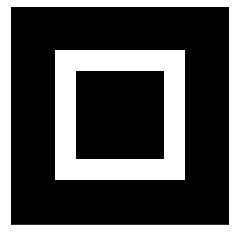

In [26]:
mem3_new = np.ones((10,10))

mem3_new[2:3,2:8] = -1
mem3_new[2:8,2:3] = -1
mem3_new[7:8,2:8] = -1
mem3_new[2:8,7:8] = -1

# plot memory
plt.imshow(mem3_new.reshape(10, 10), cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

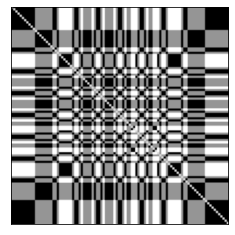

In [27]:
# YOUR CODE HERE TO UPDATE THE WEIGHTS W

W3_new = update(mem3_new.reshape(100), W2)

plt.imshow(W3_new, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

In [46]:
data_mem3_new = np.zeros((n_sims, 100)) # create data matrix to store final states

for i in tqdm(range(n_sims)): # simulate model 50 times
    # random initial condition here
    init_firing_rates = generate_noise(100)
    data_mem3_new[i, :] = runDynamics(init_firing_rates, W3_new, Beta, T, dt)
    

100%|██████████| 50/50 [00:33<00:00,  1.52it/s]


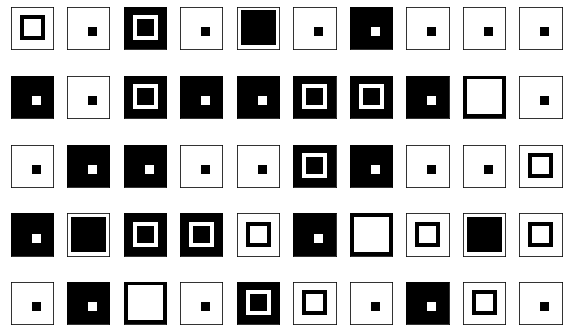

In [47]:
# plot 50 simulations
plt.figure(figsize=(8,5))    
for i in range(n_sims):   
    plt.subplot(5,10,i+1)
    plt.imshow(data_mem3_new[i, :].reshape(10,10), cmap=cmap)

    plt.xticks([])
    plt.yticks([])


plt.tight_layout()    
plt.show()

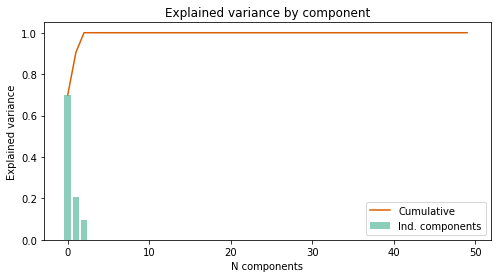

In [48]:
# YOUR CODE HERE TO COMPUTE PCS AND VARIANCE EXPLAINED PER COMPONENT
pca_mem3_new = PCA()
pca_mem3_new.fit(data_mem3_new)
explained_variance_by_component_mem3_new = pca_mem3_new.explained_variance_ratio_

# YOUR CODE HERE TO PLOT # OF PCS VS. VARIANCE EXPLAINED

plt.figure(figsize=(8,4))
plt.title('Explained variance by component')


plt.plot(range(n_sims), np.cumsum(explained_variance_by_component_mem3_new),  
     label='Cumulative', c=colors[2])

plt.bar(range(n_sims), explained_variance_by_component_mem3_new, 
         alpha=.5, color=colors[1], label='Ind. components')

plt.xlabel('N components')
plt.ylabel('Explained variance')

plt.legend()

plt.show()


In [49]:
# simulate the network
pcs_mem3_new = PCA(n_components=50).fit(data_mem3_new)

data_mem3_new_ = np.empty((n_sims, 100)) 
proj_mem3_new = np.zeros((n_sims, int(T/dt), 3)).astype(complex)

# YOUR CODE HERE TO COMPUTE 1ST & 2ND PC
first_3pca_component_new = pcs_mem3_new.components_[:3]

for i in tqdm(range(n_sims)): # simulate 50 trajectories
    # random initial condition
    init_firing_rates = generate_noise(100)
    
    data_mem3_new_[i, :], proj_mem3_new[i, :] =\
            runDynamicsPCA_2(init_firing_rates, W3_new,
                             Beta, T, dt, first_3pca_component_new)




100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


4b. How many principal components have non-zero variance explained? Why? **(2 points)**

<font color="red"> Three non zero variance explained  principal components. Three independent memories. </font>



4c. Once again, project the network in a subspace with the appropriate number of components (same as the answer to 4b). Simulate the network as in question 2. USE the function `runDynamicsPCA_2` in the code cell below, by projecting the network’s activity onto the appropriate number of principal components. 
-  Make plots of PC1 vs time, PC1 v PC2, and a 3D scatter plot of PC1, PC2, and PC3. **(3 points)**

<font color="red"> Answer in code </font>


In [50]:
# get memory for sim
sim_mem3_new=[]

for i in tqdm(range(n_sims)):
    if (data_mem3_new_[i, :].reshape(10,10)==mem1).all():
        sim_mem3_new.append(0)
    elif (data_mem3_new_[i, :].reshape(10,10)==-1*mem1).all():
        sim_mem3_new.append(1)
        
    elif (data_mem3_new_[i, :].reshape(10,10)==mem2).all():
        sim_mem3_new.append(2)
    elif (data_mem3_new_[i, :].reshape(10,10)==-1*mem2).all():
        sim_mem3_new.append(3)
        
    elif (data_mem3_new_[i, :].reshape(10,10)==mem3_new).all():
        sim_mem3_new.append(4)
    elif (data_mem3_new_[i, :].reshape(10,10)==-1*mem3_new).all():
        sim_mem3_new.append(5)
    else:
        print('outlier')
        plt.imshow(data_mem3_new_[i,:].reshape(10,10), cmap=cmap)
        
legend_elements_mem3_new = [Line2D([0], [0], color=colors_pairs[0], lw=4, label='mem 1'),
                   Line2D([0], [0], color=colors_pairs[1], lw=4, label='mem 1 mirror'),
                  Line2D([0], [0], color=colors_pairs[2], lw=4, label='mem 2'),
                  Line2D([0], [0], color=colors_pairs[3], lw=4, label='mem 2 mirror'),
                Line2D([0], [0], color=colors_pairs[4], lw=4, label='mem 3 new'),
                  Line2D([0], [0], color=colors_pairs[5], lw=4, label='mem 3 new mirror')]



100%|██████████| 50/50 [00:00<00:00, 32443.56it/s]


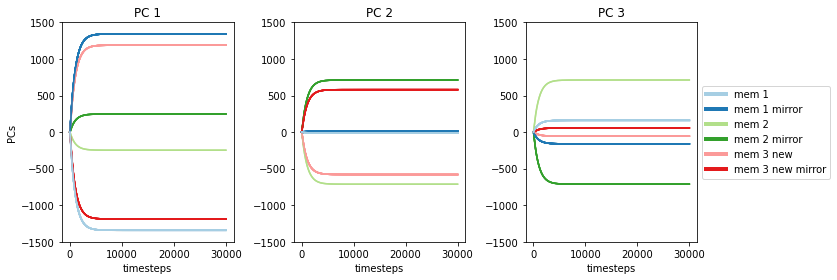

In [51]:
# YOUR CODE HERE TO PLOT PC1 VS. TIME
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title('PC 1')

for i in range(50):
    plt.plot(proj_mem3_new[i,:,0], c=colors_pairs[sim_mem3_new[i]]) 
plt.ylim(-1500,1500)
plt.xlabel('timesteps')
#plt.ylabel('PC 1')
plt.ylabel('PCs')

plt.subplot(1,3,2)
plt.title('PC 2')
# YOUR CODE HERE TO PLOT PC1 VS. TIME
for i in range(50):
    plt.plot(proj_mem3_new[i,:,1], c=colors_pairs[sim_mem3_new[i]]) 

plt.xlabel('timesteps')
#plt.ylabel('PC 2')
plt.ylim(-1500,1500)

plt.subplot(1,3,3)
plt.title('PC 3')
# YOUR CODE HERE TO PLOT PC1 VS. TIME
for i in range(50):
    plt.plot(proj_mem3_new[i,:,2], c=colors_pairs[sim_mem3_new[i]])

plt.xlabel('timesteps')
#plt.ylabel('PC 3')
plt.ylim(-1500,1500)

plt.tight_layout()
plt.legend(handles=legend_elements_mem3_new, 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

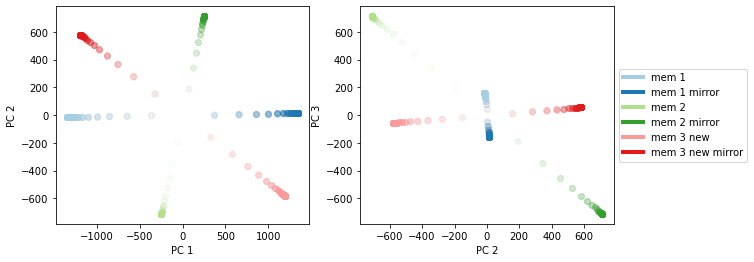

In [52]:
# YOUR CODE HERE TO PLOT PC1 VS. PC2
plt.figure(figsize=(10,4))
for j in range(2):
    plt.subplot(1,2,j+1)
    plt.xlabel('PC {}'.format(j+1))
    plt.ylabel('PC {}'.format(j+2))
    for i in range(n_sims):
        for t in np.linspace(0, 10e3 ,30, dtype=int):
            plt.scatter(proj_mem3_new[i,t,j], 
                        proj_mem3_new[i,t,j+1], 
                        alpha=t/time_steps, 
                        color=colors_pairs[sim_mem3_new[i]])

plt.legend(handles=legend_elements_mem3_new, 
           loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

### transperacy spectrum coresponds to time step, 
# where brightest color is the final one.

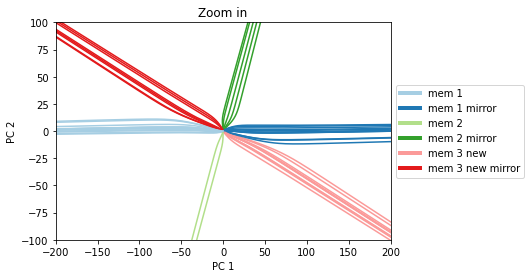

In [53]:
plt.title('Zoom in')
for i in range(n_sims):
    plt.plot(proj_mem3_new[i,:,0], 
                proj_mem3_new[i,:,1], 
                color=colors_pairs[sim_mem3_new[i]])

# Create the figure
plt.legend(handles=legend_elements_mem3_new, 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim(-200,200)
plt.ylim(-100,100)
plt.show()

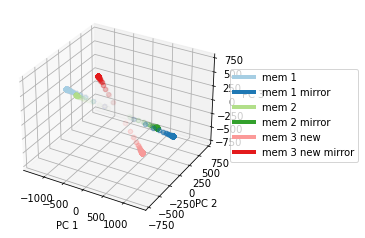

In [54]:
# YOUR CODE HERE FOR A 3D PLOT OF PC1 VS. PC2 VS. PC3

fig = plt.figure()
ax = plt.axes(projection='3d')

    
for i in range(n_sims):
    for t in np.linspace(0, 10e3 ,30, dtype=int):
        ax.scatter3D(proj_mem3_new[i,t,0], 
              proj_mem3_new[i,t,1], 
              proj_mem3_new[i,t,2], 
                     color=colors_pairs[sim_mem3_new[i]],
                     alpha=t/time_steps)

plt.legend(handles=legend_elements_mem3_new, 
           loc='center left', bbox_to_anchor=(1, 0.5))
        
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')


plt.show()


### transperacy spectrum coresponds to time step, 
# where brightest color is the final one.

4d. Reviewing these plots, do they separate the trajectories? Is there anything different about these trajectories/their separation compared to the networks with fewer memories?
Why does the overlap in memories matter?  **(2 points)**

<font color="red"> The plots do separate the memories. The first PC still does seperate all trajectories (so as PC2 and PC3).
    The overlap in memories, as demonstrated below, yields spurios memories, stored by the network, which introduces additional complexity to the system - thus, resulting in more PCs. </font>


BONUS (3 points): Repeat questions 4a and 4b with Memory 3 instead. Jot down a 2 sentence summary of what you notice about the final states of the network.

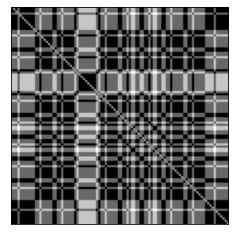

In [37]:
# YOUR CODE HERE TO UPDATE THE WEIGHTS W

W3 = update(mem3.reshape(100), W2)

plt.imshow(W3, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
n_sims_new=100 ## increased due to increased # memories
data_mem3 = np.zeros((n_sims_new, 100)) # create data matrix to store final states

for i in tqdm(range(n_sims_new)): # simulate model 50 times
    # random initial condition here
    init_firing_rates = generate_noise(100)
    data_mem3[i, :] = runDynamics(init_firing_rates, W3, Beta, T, dt)
    

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


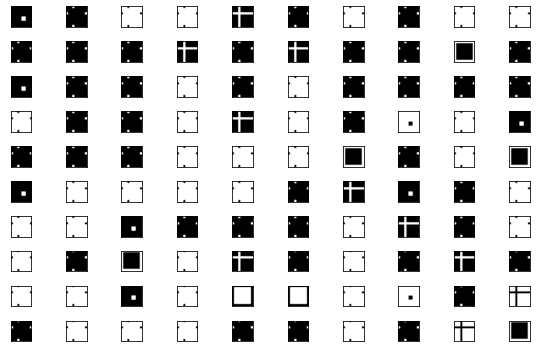

In [39]:
# plot 50 simulations
plt.figure(figsize=(8,5))    
for i in range(n_sims_new):   
    plt.subplot(10,10,i+1)
    plt.imshow(data_mem3[i, :].reshape(10,10), cmap=cmap)
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout() 

plt.show()

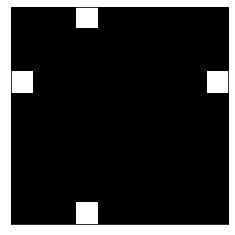

In [40]:
## spur mem
plt.imshow(data_mem3[1,:].reshape(10,10), cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()
spur_mem = data_mem3[1,:].reshape(10,10)

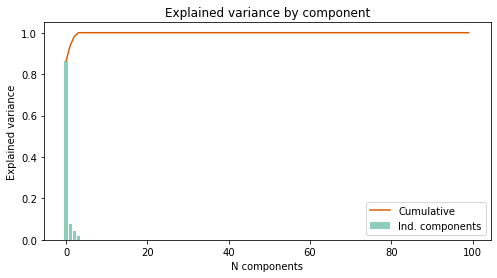

In [41]:
# YOUR CODE HERE TO COMPUTE PCS AND VARIANCE EXPLAINED PER COMPONENT
pca_mem3 = PCA()
pca_mem3.fit(data_mem3)
explained_variance_by_component_mem3 = pca_mem3.explained_variance_ratio_

# YOUR CODE HERE TO PLOT # OF PCS VS. VARIANCE EXPLAINED

plt.figure(figsize=(8,4))
plt.title('Explained variance by component')

plt.plot(range(n_sims_new), np.cumsum(explained_variance_by_component_mem3),  
     label='Cumulative', c=colors[2])

plt.bar(range(n_sims_new), explained_variance_by_component_mem3, 
         alpha=.5, label='Ind. components', color=colors[1])

plt.xlabel('N components')
plt.ylabel('Explained variance')

plt.legend()

plt.show()


In [42]:
# simulate the network
pcs_mem3 = PCA(n_components=50).fit(data_mem3)

data_mem3_ = np.empty((n_sims_new, 100)) 
proj_mem3 = np.zeros((n_sims_new, int(T/dt), 4)).astype(complex)

# YOUR CODE HERE TO COMPUTE 1ST & 2ND PC
first_4pca_component = pcs_mem3.components_[:4]

for i in tqdm(range(n_sims_new)): # simulate 50 trajectories
    # random initial condition
    init_firing_rates = generate_noise(100)
    
    data_mem3_[i, :], proj_mem3[i, :] =\
            runDynamicsPCA_2(init_firing_rates, W3,
                             Beta, T, dt, first_4pca_component)




100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


4b. How many principal components have non-zero variance explained? Why? **(2 points)**

<font color="red"> As mentioned above, overlapping memories yields a more complex network. There are 4 non-zero variance explained principal components. This corresponds with the number of de-facto memories stored in the network. See the simulations above- generating 4 different memories: 3 desired and 1 spurious.</font>



4c. Once again, project the network in a subspace with the appropriate number of components (same as the answer to 4b). Simulate the network as in question 2. USE the function `runDynamicsPCA_2` in the code cell below, by projecting the network’s activity onto the appropriate number of principal components. 
-  Make plots of PC1 vs time, PC1 v PC2, and a 3D scatter plot of PC1, PC2, and PC3. **(3 points)**

<font color="red"> Answer in code </font>


In [43]:
# get memory for sim
sim_mem3=[]

for i in tqdm(range(n_sims_new)):
    if (data_mem3_[i, :].reshape(10,10)==mem1).all():
        sim_mem3.append(0)
    elif (data_mem3_[i, :].reshape(10,10)==-1*mem1).all():
        sim_mem3.append(1)
        
    elif (data_mem3_[i, :].reshape(10,10)==mem2).all():
        sim_mem3.append(2)
    elif (data_mem3_[i, :].reshape(10,10)==-1*mem2).all():
        sim_mem3.append(3)
        
    elif (data_mem3_[i, :].reshape(10,10)==mem3).all():
        sim_mem3.append(4)
    elif (data_mem3_[i, :].reshape(10,10)==-1*mem3).all():
        sim_mem3.append(5)
    elif  (data_mem3_[i, :].reshape(10,10).round(1)==\
                                   spur_mem.round(1)).all():
        sim_mem3.append(6)
    elif  (data_mem3_[i, :].reshape(10,10).round(1)==\
                           -1*spur_mem.round(1)).all():
        sim_mem3.append(7)
    else:
        print('outlier')

legend_elements_mem3 = [Line2D([0], [0], color=colors_pairs[0], lw=4, label='mem 1'),
                   Line2D([0], [0], color=colors_pairs[1], lw=4, label='mem 1 mirror'),
                  Line2D([0], [0], color=colors_pairs[2], lw=4, label='mem 2'),
                  Line2D([0], [0], color=colors_pairs[3], lw=4, label='mem 2 mirror'),
                Line2D([0], [0], color=colors_pairs[4], lw=4, label='mem 3'),
                  Line2D([0], [0], color=colors_pairs[5], lw=4, label='mem 3 mirror'),
                   Line2D([0], [0], color=colors_pairs[6], lw=4, label='spurios mem'),  
                Line2D([0], [0], color=colors_pairs[7], lw=4, label='spurios mem mirror')]



100%|██████████| 100/100 [00:00<00:00, 12528.16it/s]


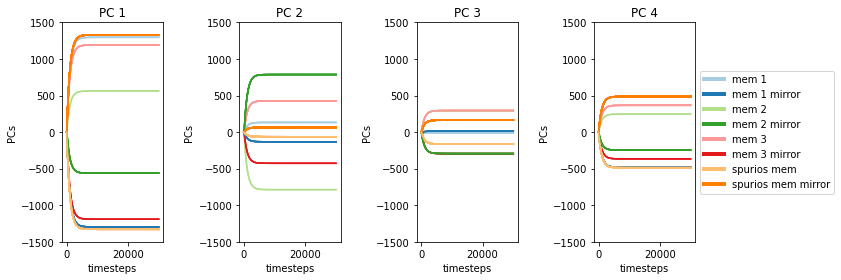

In [44]:
# YOUR CODE HERE TO PLOT PC1 VS. TIME
plt.figure(figsize=(10,4))

for j in range(4):
    plt.subplot(1,4,j+1)
    plt.title('PC {}'.format(j+1))

    for i in range(n_sims_new):
        plt.plot(proj_mem3[i,:,j], c=colors_pairs[sim_mem3[i]]) 
    
    plt.ylim(-1500,1500)
    plt.xlabel('timesteps')
    #plt.ylabel('PC 1')
    plt.ylabel('PCs')

plt.tight_layout()
plt.legend(handles=legend_elements_mem3, 
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

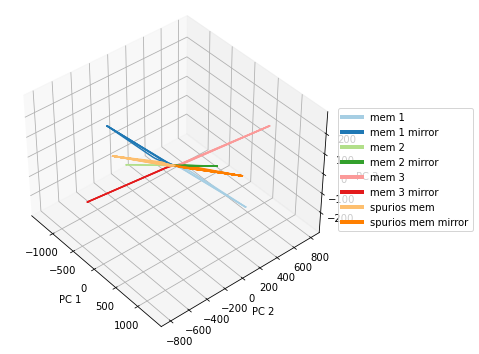

In [45]:
# YOUR CODE HERE FOR A 3D PLOT OF PC1 VS. PC2 VS. PC3

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

    
for i in range(n_sims_new):
    ax.plot3D(proj_mem3[i,:,0], 
              proj_mem3[i,:,1], 
              proj_mem3[i,:,2], 
                     color=colors_pairs[sim_mem3[i]])

plt.legend(handles=legend_elements_mem3, 
           loc='center left', bbox_to_anchor=(1, 0.5))
        
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.view_init(40, -40)

plt.show()


### transperacy spectrum coresponds to time step, 
# where brightest color is the final one.

4d. Reviewing these plots, do they separate the trajectories? Is there anything different about these trajectories/their separation compared to the networks with fewer memories?
Why does the overlap in memories matter?  **(2 points)**

<font color="red"> The plots do separate the memories. The first PC still does seperate all trajectories (so as PC2, PC3, and PC4). The overlap does not seem to affect the seperability as much as it just adds an aditional memory, resulting in an additional PC.</font>
